# Recurrent Neural Networks

In this series of exercises, we are going to see some basic applications of Recurrent Neural Networks (RNNs).

In [1]:
# classical imports
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

## First RNN: sinusoidal wave

This toy problem is an extremely simple illustration of a univariate (one-feature) time series. Our objective will be to build a model able to correctly predict the next value in the series, given a variable amount of sequential values from previous timesteps. First, let's generate some data and visualize the result.

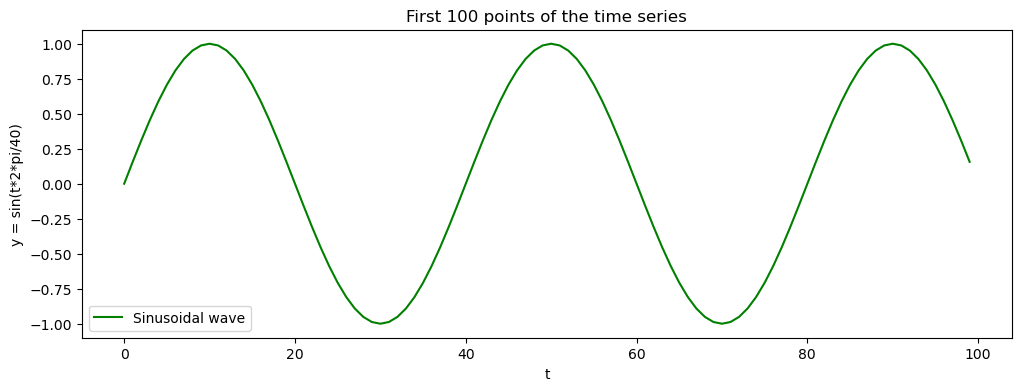

In [2]:
# since we are creating artificial data, we can operate directly on tensors
t = torch.linspace(0,799,800)
y = torch.sin(t*2*3.1416/40)

# let's just visualize the first 100 samples
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(t[:100], y[:100], color='green', label="Sinusoidal wave")
ax.set_xlabel("t")
ax.set_ylabel("y = sin(t*2*pi/40)")
ax.set_title("First 100 points of the time series")
ax.legend(loc='best')

Now, we split the data into training and test (let's forget the validation set, for the moment).

In [3]:
test_size = 40

# negative indices start indexing from the last part of the tensor/array (e.g. last element is y[-1])
train_set = y[:-(test_size)]
test_set = y[-test_size:]

print("Total data: %d samples; Training set: %d samples; Test set: %d samples" %
      (y.shape[0], train_set.shape[0], test_set.shape[0]))

Total data: 800 samples; Training set: 760 samples; Test set: 40 samples


If this were a classical neural network, we would be done; but in this case, we need to actually create training sequences, where we give a few input values to the RNN, and then have the next value in the sequence as output to be predicted, to be used as a ground truth. We can slide a window of given size over the single samples of our training set to create this new training data.

Creating input sequences of 40 samples
Created a total of 720 input sequences


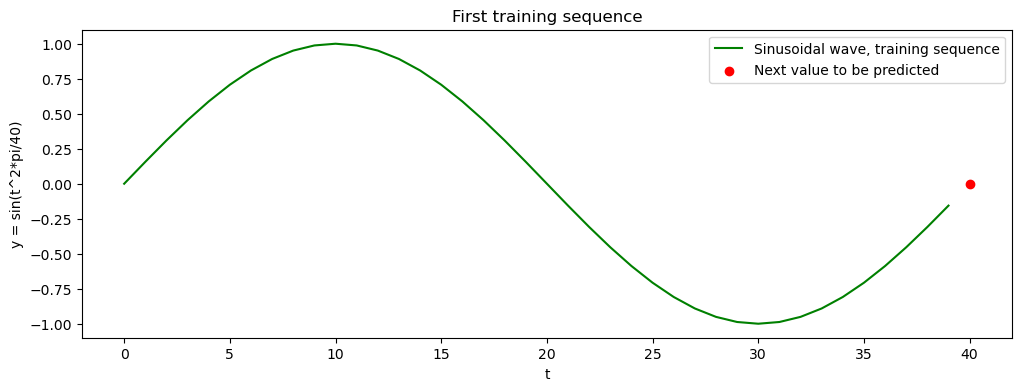

In [4]:
# we can use a simple function to automatically create the training data;
# it's going to return lists of tuples (x_tensor, y_tensor), where x_tensor
# are the values in the previous time steps, and y_tensor is the next value
# to be predicted
def input_data(sequence, window_size):
    out = []
    L = len(sequence)

    for i in range(L-window_size):
        window = sequence[i:i+window_size]
        label = sequence[i+window_size:i+window_size+1]
        out.append((window, label))

    return out

window_size = 40
print("Creating input sequences of %d samples" % window_size)
train_data = input_data(train_set, window_size)
print("Created a total of %d input sequences" % len(train_data))

# let's take a look at the first training sequence
x_tensor = train_data[0][0] # training samples for this sequence
y_tensor = train_data[0][1] # next value to be predicted
t = [i for i in range(0, x_tensor.shape[0])]
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(t, x_tensor, color='green', label="Sinusoidal wave, training sequence")
ax.scatter(t[-1] + 1, y_tensor, color='red', label="Next value to be predicted")
ax.set_xlabel("t")
ax.set_ylabel("y = sin(t^2*pi/40)")
ax.set_title("First training sequence")
ax.legend(loc='best')

We finally get to our favorite part, where we need to create a new model, inheriting from torch.nn.Module.

In [12]:
class MyFirstLSTM(nn.Module):

    # we need to specify the size of the hidden state, or in other word, the tensor
    # storing the history
    def __init__(self,input_size = 1, hidden_size = 1, out_size = 1) :
        super().__init__()
        # the hidden state is initialized to zeros
        self.hidden_size = hidden_size
        self.hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))
        # and the neural network simply has two modules:
        # - a LSTM, that will be unrolled to adjust for sequences of different length
        # - and a simple linear module, that will output the next element in the sequence
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, out_size)

    # forward pass
    def forward(self, sequence) :
        # the LSTM module is called with the input sequence and the initial hidden state (all zeros)
        # stored inside the attribute self.hidden of this class
        lstm_out, self.hidden = self.lstm(sequence.view(len(sequence), 1, -1), self.hidden)
        print("LSTM output:", lstm_out.shape)
        print("Hidden state (2 parts): %s ; %s" % (str(self.hidden[0].shape), str(self.hidden[1].shape)))
        pred = self.linear(lstm_out.view(len(sequence),-1))
        return pred[-1]

torch.manual_seed(42)
my_first_lstm = MyFirstLSTM(hidden_size=5)
print("My first LSTM network has %d parameters!" % sum(p.numel() for p in my_first_lstm.parameters() if p.requires_grad))
print("Of which %d inside the LSTM cells" % sum(p.numel() for p in my_first_lstm.lstm.parameters() if p.requires_grad))

My first LSTM network has 166 parameters!
Of which 160 inside the LSTM cells


Before trying to run the code, try setting the size of the hidden state to 1. This will make the LSTM module use a single unit, so we can check that the number of parameters is what we expect. If they look a bit more than what you would have anticipated, it's because pytorch keeps lots of biases as two separate values instead of one, see the [LSTM module documentation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) for more details.

We can now proceed with the training.

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

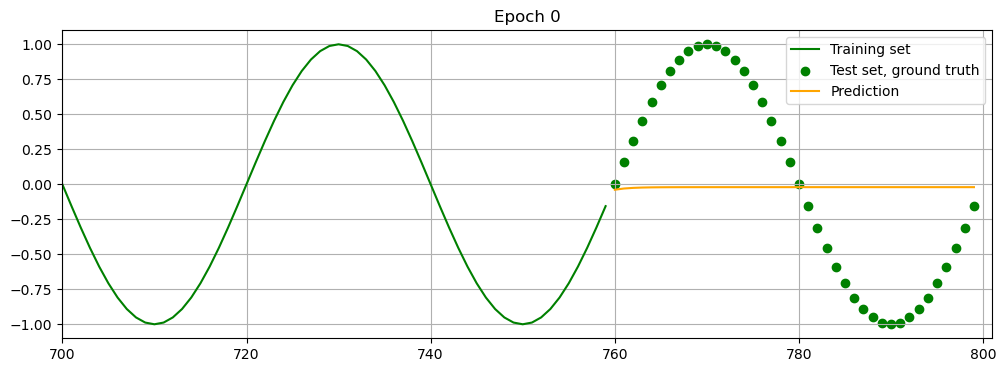

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

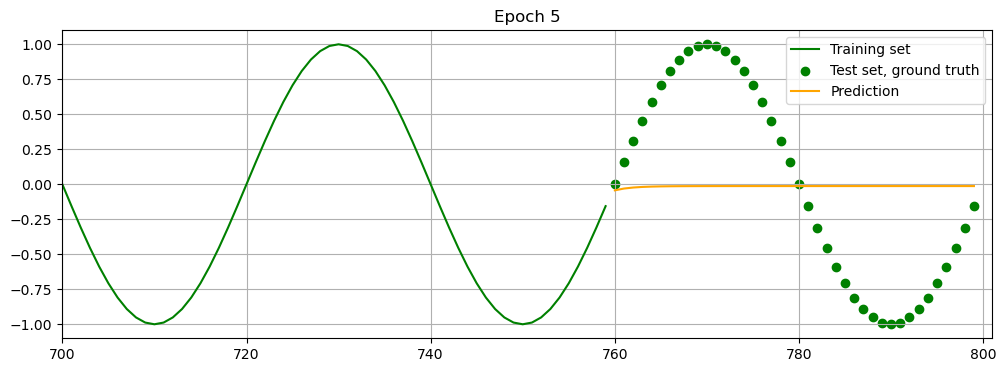

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
Epoch 9, loss: 7.3998e-03
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.S

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

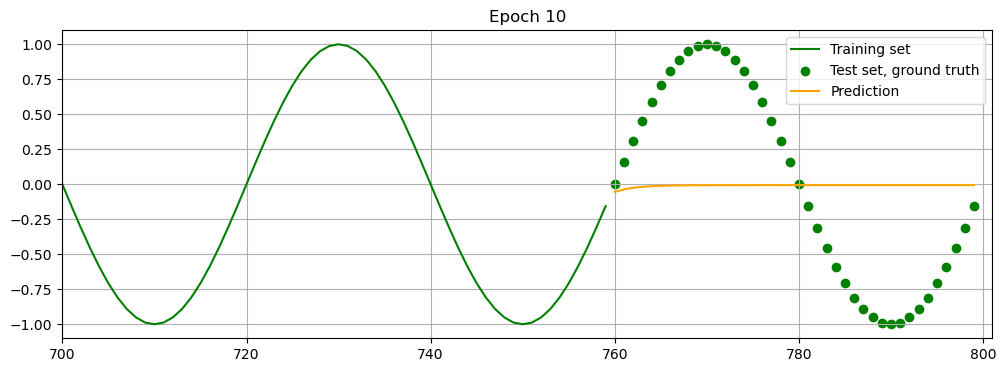

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([40, 1, 5])
Hidden sta

KeyboardInterrupt: 

In [13]:
# as usual, we prepare the optimization loop
loss = nn.MSELoss()
optimizer = torch.optim.Adam(my_first_lstm.parameters(), lr=1e-5)

max_epochs = 20
future = 40

for epoch in range(0, max_epochs):

    for seq, y_train in train_data:
        optimizer.zero_grad()
        my_first_lstm.hidden = (torch.zeros(1, 1, my_first_lstm.hidden_size),
                       torch.zeros(1, 1, my_first_lstm.hidden_size))

        y_pred = my_first_lstm(seq)
        train_loss = loss(y_pred, y_train)
        train_loss.backward()
        optimizer.step()

    print("Epoch %d, loss: %.4e" % (epoch, train_loss.item()))

    # this part here is just to offer a visualization of the training process,
    # normally we should NEVER use the test set during training
    if epoch % 5 == 0 or epoch == max_epochs-1 :
      preds = train_set[-window_size:].tolist()
      for f in range(0, future) :
          seq = torch.FloatTensor(preds[-window_size:])
          with torch.no_grad() :
              my_first_lstm.hidden = (torch.zeros(1, 1, my_first_lstm.hidden_size),
                            torch.zeros(1, 1, my_first_lstm.hidden_size))
              preds.append(my_first_lstm(seq).item())

      loss_train = loss(torch.tensor(preds[-window_size:]), y[760:])
      print("Performance on test set: %.4e" % loss_train.item())

      fig, ax = plt.subplots(figsize=(12,4))
      ax.set_xlim(700, 801) # we visualize only the last part of the data set
      ax.grid(True)
      ax.plot(y.numpy()[:760], color='green', label="Training set")
      ax.scatter(range(760, 800), y.numpy()[760:], color='green', label="Test set, ground truth")
      ax.plot(range(760, 800), preds[window_size:], color='orange', label="Prediction")
      ax.legend(loc='best')
      ax.set_title("Epoch %d" % epoch)
      plt.show()

Now that the network is trained, we can check what happens if we give it an input sequence of different size, asking it to predict more values than what it was trained on.

LSTM output: torch.Size([80, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([81, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([82, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([83, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([84, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([85, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([86, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([87, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([88, 1, 5])
Hidden state (2 parts): torch.Size([1, 1, 5]) ; torch.Size([1, 1, 5])
LSTM output: torch.Size([89, 1, 5])
Hidden sta

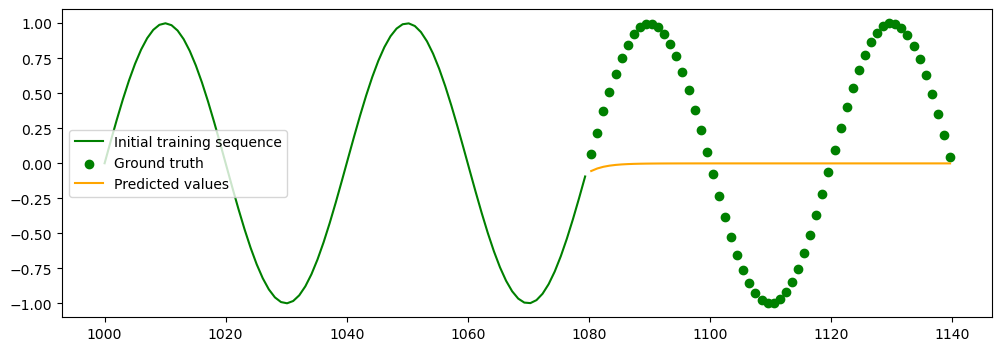

In [14]:
# let's generate completely new data
t_new = torch.linspace(1000, 1200, 200)
y_new = torch.sin(t_new*2*3.1416/40)

input_sequence_length = 80
input_sequence = y_new[0:input_sequence_length] # first samples
local_input_sequence = input_sequence.clone() # create a separate tensor, to avoid messing up the original
pred_sequence_length = 60
pred_sequence = torch.zeros(60)

# we do not need to perform other backward passes, so we can just perform a forward pass
# with the torch.no_grad() context, to avoid recreating the computational graph
with torch.no_grad() :

  for i in range(0, pred_sequence_length) :
    # prepare the LSTM network, setting its initial hidden state to zero
    my_first_lstm.hidden = (torch.zeros(1, 1, my_first_lstm.hidden_size),
                              torch.zeros(1, 1, my_first_lstm.hidden_size))

    # obtain the prediction for the sequence so far
    y_pred = my_first_lstm(local_input_sequence)

    # store the predicted element
    pred_sequence[i] = y_pred.item()

    # add the predicted element to the next input sequence, using concatenation
    local_input_sequence = torch.cat((local_input_sequence, y_pred), dim=0)

# check the results
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(t_new[:input_sequence_length], input_sequence, color='green', label="Initial training sequence")
ax.scatter(t_new[input_sequence_length:input_sequence_length+pred_sequence_length], y_new[input_sequence_length:input_sequence_length+pred_sequence_length],
           color='green', label="Ground truth")
ax.plot(t_new[input_sequence_length:input_sequence_length+pred_sequence_length], pred_sequence, color='orange', label="Predicted values")
ax.legend(loc='best')

## RNN for classification

We are now going